# **LONG STEPS in GRADIENT DESCENT METHODS**

## **Install**

### Firedrake

In [1]:
try:
    import google.colab  # noqa: F401
except ImportError:
    from firedrake import *
else:
    try:
        from firedrake import *
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh"
        !bash "/tmp/firedrake-install.sh"
        from firedrake import *

--2025-10-15 12:34:49--  https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4767 (4.7K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.66K  --.-KB/s    in 0.001s  

2025-10-15 12:34:49 (4.33 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4767/4767]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/a082

### Other

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

## **General functions**

### Constrained optimisation Firedrake code

In [18]:
def constrained_optimisation(nx=2**7, degree=1, gamma=2**32, max_iters=2**6, energy_exact=None, h="newton"):
    # UFL-ify constants
    gamma = Constant(gamma)

    # Mesh
    mesh = UnitSquareMesh(nx, nx, quadrilateral=True)
    V = FunctionSpace(mesh, "Q", degree)

    # Constraint function f(x, y): circular bump
    x, y = SpatialCoordinate(mesh)
    cylinders = (
        ((0.4, 0.6), 0.3, 1.0),
        ((0.6, 0.4), 0.2, 0.8),
    )
    f = conditional((x - cylinders[0][0][0])**2 + (y - cylinders[0][0][1])**2 <= cylinders[0][1]**2, cylinders[0][2],
        conditional((x - cylinders[1][0][0])**2 + (y - cylinders[1][0][1])**2 <= cylinders[1][1]**2, cylinders[1][2],
        0.0
    ))

    # Functions
    u = Function(V)
    u_ = Function(V)
    v = TestFunction(V)

    # BCs
    bcs = DirichletBC(V, 0.0, "on_boundary")

    # Energy
    h1_seminorm = 0.5 * inner(grad(u_), grad(u_)) * dx
    constraint_viol = 0.5 * conditional(lt(u_, f), (u_ - f)**2, 0) * dx
    E = h1_seminorm + gamma * constraint_viol

    # Check method and normalise input
    use_newton = isinstance(h, str) and h.lower() == "newton"
    if not use_newton:
        if np.isscalar(h):
            h = [float(h)]
        elif isinstance(h, (list, tuple, np.ndarray)):
            h = list(np.array(h, dtype=float).ravel())
        else:
            raise ValueError("h must be 'newton', a scalar, or an array-like of step sizes")
        h_len = len(h)
        if h_len == 0:
            raise ValueError("Step sequence h must be non-empty")
        h_ = Constant(h[0])

    # Residual
    if use_newton:
        F = (
            inner(grad(u), grad(v))
          + gamma * conditional(lt(u_, f), (u - f) * v, 0)
        ) * dx
    else:
        h1_norm = (
            inner(grad(u - u_), grad(v))
          + gamma * inner(u - u_, v)
        ) * dx
        E_prime = (
            inner(grad(u_), grad(v))
          + gamma * conditional(lt(u_, f), (u_ - f) * v, 0)
        ) * dx
        F = h1_norm + h_ * E_prime

    # Solve loop
    energy = assemble(E)
    energies = [energy]
    print(GREEN % f"Energy: {energy}")
    for i in range(max_iters):
        if use_newton:
            print(BLUE % f"Newton iterate {i+1}...")
        elif h_len == 1:
            print(BLUE % f"GD iterate {i+1}...")
        else:
            print(BLUE % f"GD iterate {i+1}, step size {h[i % h_len]}...")
            h_.assign(h[i % h_len])
        solve(F == 0, u, bcs)
        u_.assign(u)
        energy = assemble(E)
        energies += [energy]
        print(GREEN % f"Energy: {energy}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

    # Left: log energy error convergence
    energy_errors = [abs(energy - energy_exact) for energy in energies]

    if use_newton:
        ax1.semilogy(range(len(energy_errors)), energy_errors, marker='o')
    else:
        ax1.loglog(range(len(energy_errors)), energy_errors, marker='o')
    ax1.set_xlabel("Newton iterate")
    ax1.set_title("Energy errors")
    ax1.grid(True, which="both", ls="--", alpha=0.6)

    # Right: contour plot
    tpc = tripcolor(u, axes=ax2)
    # Create contour lines
    tricontour(u, levels=10, colors='w', linewidths=1.0, axes=ax2)
    ax2.set_aspect('equal')
    ax2.set_title("Contour plot")
    fig.colorbar(tpc, ax=ax2, orientation='vertical')
    for (center, width, _) in cylinders:
        circ = Circle(center, width, fill=False, color='k', linestyle='-', linewidth=2.0)
        ax2.add_patch(circ)

    plt.tight_layout()
    plt.show()

### Gradient descent

In [4]:
def quad(x, A):
    return 1/2 * np.dot(x, A @ x)

def grad_quad(x, A):
    return A @ x

def gd_quad(x0=None, A=np.diag([1.0, 5.0]), h="linesearch", n_steps=20):
    """
    Gradient descent on quadratic 1/2 x^T A x.
    Args:
      x0: initial point (shape (2,) for 2D)
      A: SPD matrix
      h:
        - "cg": conjugate gradient (CG)
        - "linesearch": exact line search step each iteration
        - scalar: fixed step size normalized by 1/L
        - list/tuple/np.ndarray: periodic sequence of normalized step sizes
      n_steps: number of iterations
    Returns:
      path: (N+1, d) array of iterates
      errors: (N+1,) array of energies 1/2 x^T A x
      norm_steps: (N,) array of normalized line-search steps lip * ||g||^2 / (g^T A g) when using linesearch, else None
    """
    if x0 is None:
        x0 = np.array([1 for _ in range(np.shape(A)[0])])
    path = [x0]
    errors = [quad(x0, A)]
    norm_steps = []
    x = x0

    # Detect linesearch or CG vs periodic/constant step
    use_cg = isinstance(h, str) and h.lower() == "cg"
    use_linesearch = isinstance(h, str) and h.lower() == "linesearch"
    if not use_linesearch and not use_cg:
        # Normalize h into a list of floats (periodic sequence)
        if np.isscalar(h):
            h = [float(h)]
        elif isinstance(h, (list, tuple, np.ndarray)):
            h = list(np.array(h, dtype=float).ravel())
        else:
            raise ValueError("h must be 'cg', 'linesearch', a scalar, or an array-like of step sizes")
        h_len = len(h)
        if h_len == 0:
            raise ValueError("Step sequence h must be non-empty")
        i = 0
    if use_cg:
        r = - grad_quad(x, A)
        p = r

    lip = np.linalg.norm(A, ord=2)

    for _ in range(n_steps):
        g = grad_quad(x, A)
        if use_cg:
            rr = np.dot(r, r)
            alpha = rr / quad(p, A) / 2
            x = x + alpha * p
            r = r - alpha * grad_quad(p, A)
            beta = np.dot(r, r) / rr
            p = r + beta * p
        elif use_linesearch:
            gTAg = 2 * quad(g, A)
            gg = np.dot(g, g)
            if gTAg == 0.0:
                gTAg = 1e-12  # avoid division by zero
            alpha = gg / gTAg
            # record normalized step size lip * alpha
            norm_steps.append(lip * alpha)
            x = x - alpha * g
        else:
            x = x - (h[i % h_len] / lip) * g
            i += 1
        path.append(x)
        errors.append(quad(x, A))

    path = np.array(path)
    errors = np.array(errors)
    if use_linesearch:
        norm_steps = np.array(norm_steps)
    else:
        norm_steps = None
    return path, errors, norm_steps

def gd_quad_plot2D(x0=None, A=np.diag([1.0, 5.0]), h="linesearch", n_steps=20, title=None):
    """
    Gradient descent with plotting if test is 2D.
    """
    # Run gradient descent
    path, errors, norm_steps = gd_quad(x0=x0, A=A, h=h, n_steps=n_steps)

    # Plot
    if isinstance(h, str) and h.lower() == "linesearch":
        _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4.5))
    else:
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))
        ax3 = None
    # Contours
    x = np.linspace(-3, 3, 100); y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    # Vectorized evaluation of quadratic form over grid
    XY = np.stack([X.ravel(), Y.ravel()], axis=1)  # shape (N*N, 2)
    Z = (0.5 * np.einsum('ij,ij->i', XY, (XY @ A))).reshape(X.shape)
    ax1.contour(X, Y, Z, levels=20)
    ax1.plot(path[:,0], path[:,1], 'r--', label='GD path')
    ax1.plot(path[0,0], path[0,1], 'ro', label='initial', markersize=8)
    ax1.set_aspect('equal')
    ax1.set_title("Path of x" if title is None else title)
    ax1.legend()

    # Convergence
    ax2.semilogy(range(len(errors)), errors + 1e-15, 'b.-')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Energy')
    ax2.set_title('Convergence rate')

    # Normalized step sizes panel for line search
    if ax3 is not None and norm_steps is not None:
        ax3.plot(range(1, len(norm_steps)+1), norm_steps, 'g.-')
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('h')
        ax3.set_title('Normalised line-search steps')
        ax3.grid(True, which="both", ls="--", alpha=0.6)

    plt.tight_layout()

    plt.show()

def gd_quad_plotND(x0=None, A=np.diag([1.0, 5.0]), h="linesearch", n_steps=20, title=None):
    """
    Gradient descent with plotting if test is ND.
    """
    # Run gradient descent
    _, errors, norm_steps = gd_quad(x0=x0, A=A, h=h, n_steps=n_steps)

    # Plot
    if isinstance(h, str) and h.lower() == "linesearch":
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))
    else:
        _, ax1 = plt.subplots(1, 1, figsize=(6, 4.5))
        ax2 = None

    # Convergence
    ax1.loglog(np.arange(1, len(errors)), errors[1:] + 1e-15, 'b.-')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Energy')
    ax1.set_title('Convergence rate')

    # Normalized step sizes panel for line search
    if ax2 is not None and norm_steps is not None:
        ax2.plot(range(1, len(norm_steps)+1), norm_steps, 'g.-')
        ax2.set_xlabel('Iteration')
        ax2.set_ylabel('h')
        ax2.set_title('Normalised line-search steps')
        ax2.grid(True, which="both", ls="--", alpha=0.6)

    plt.tight_layout()

    plt.show()

## **Motivation:** When Newton fails

We're all used to using Newton, and who can blame us?

When it works, the convergence rate is superb: $\mathcal{O}(C^{- n^2})$.*
However, it's not always the best tool for the job:

1. Newton–Kantorovich (i.e. the convergence result for Newton in the continuous setting) requires **local Lipschitz differentiability** of the residual. It's relatively easy to cook up situations where this is violated, e.g. say we want to minimise this funky functional:
$$
E(u) := \frac{1}{2}\int\|\nabla u\|^2 + \frac{\lambda}{2}\int_{u < f}(u-f)^2.
$$
This kind of functional** is pretty much the simplest way to approach constrained optimisation, i.e. as $\lambda \to \infty$, we expect the minimiser of $E$ to be the $u$ that minimises $\int \|\nabla u\|^2$ subject to $u \ge f$.

    However, the (Fréchet) derivative of $E$,
    $$
    E'(u; v) = \int \nabla u \cdot \nabla v + \lambda\int_{u \le f}(u - f)v,
    $$
    is **not Lipschitz differentiable** in $H^1$.
    No surprise then, we see Newton really struggles to minimise $E$.

> **It's a bit technical about whether this result holds in the continuous setting, but let's just assume it does.*

> ***C.F. Nemystkii operators.*

Energy: 696906895.1071609
Newton iterate 1...
Energy: 12890.710975199065
Newton iterate 2...
Energy: 1279.341866305218
Newton iterate 3...
Energy: 149502.48704439096
Newton iterate 4...
Energy: 524217.3057128633
Newton iterate 5...
Energy: 15749.330759318875
Newton iterate 6...
Energy: 1095.9473851632272
Newton iterate 7...
Energy: 163.70296743472477
Newton iterate 8...
Energy: 33216.78610500322
Newton iterate 9...
Energy: 3842.005751835477
Newton iterate 10...
Energy: 120.10424475643951
Newton iterate 11...
Energy: 23.968466296730472
Newton iterate 12...
Energy: 34.30857582576243
Newton iterate 13...
Energy: 60.667092835121714
Newton iterate 14...
Energy: 23.919873323398175
Newton iterate 15...
Energy: 18.493354537856973
Newton iterate 16...
Energy: 90.82133566828763
Newton iterate 17...
Energy: 12.906727919686881
Newton iterate 18...
Energy: 9.27879468119835
Newton iterate 19...
Energy: 7.662638974231563
Newton iterate 20...
Energy: 10.109659367983282
Newton iterate 21...
Energy: 15.

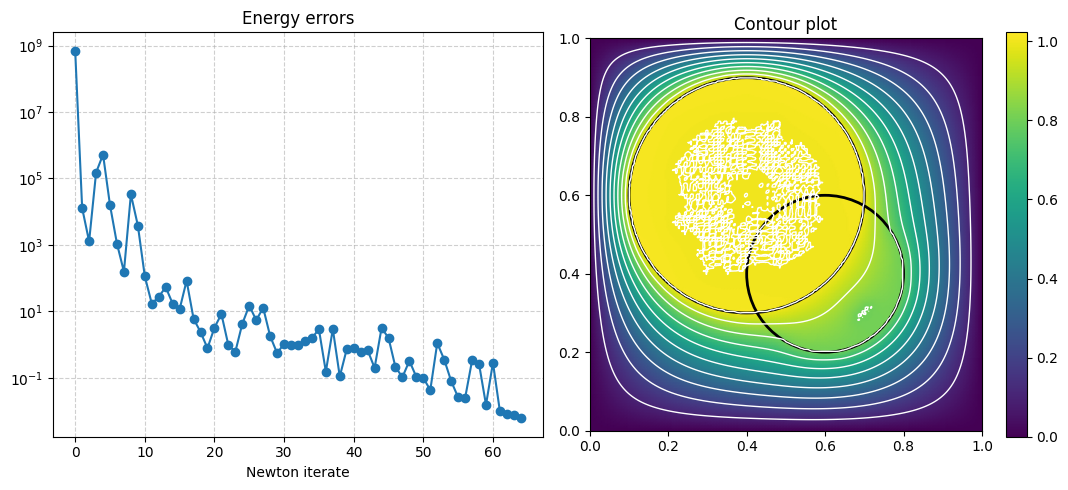

In [19]:
constrained_optimisation(nx=2**7, degree=1, gamma=2**32, max_iters=2**6, energy_exact=6.881792651781006)

2. Something we've all encountered:
Your initial guess might just lie **outside an attractive basin**.
This is especially common when you're looking at **highly nonlinear** problems with **multiple solutions**.

3. In Newton's method, the Jacobian, i.e. the linear operator we have to invert, changes at every iteration.
For instance, when minimising an energy functional, the Newton iterates are given by
$$
0 = E'(u_n; v) + E''(u_n; u_{n+1} - u_n, v).
$$
The Jacobian here is then $E''(u_n; \cdot, \cdot)$.

    **Assembly** can massively **dominate computation time**, so anything we can do to avoid repeated assembly of this Jacobian is welcome.
    This is especially true when you're at a high order, and you don't have so many tricks at your disposal to ensure this linear operator remains sparse.

Energy: 696964017.4677631
Newton iterate 1...
Energy: 589023.0282176352
Newton iterate 2...
Energy: 43522.487828276564
Newton iterate 3...
Energy: 2260.1594453840817
Newton iterate 4...
Energy: 287.18959588464395
Newton iterate 5...
Energy: 104.65795805537135
Newton iterate 6...
Energy: 89.95633282180269
Newton iterate 7...
Energy: 45.91706333351465
Newton iterate 8...
Energy: 28.411412361757133
Newton iterate 9...
Energy: 20.171480599525005
Newton iterate 10...
Energy: 12.298812235182986
Newton iterate 11...
Energy: 11.411671730111346
Newton iterate 12...
Energy: 17.32805570234971
Newton iterate 13...
Energy: 12.481823848931107
Newton iterate 14...
Energy: 9.991273860598277
Newton iterate 15...
Energy: 16.69282248714758
Newton iterate 16...
Energy: 15.27194618591934
Newton iterate 17...
Energy: 13.781616430088029
Newton iterate 18...
Energy: 15.13871495111502
Newton iterate 19...
Energy: 12.186430152713935
Newton iterate 20...
Energy: 15.455472617328681
Newton iterate 21...
Energy: 11

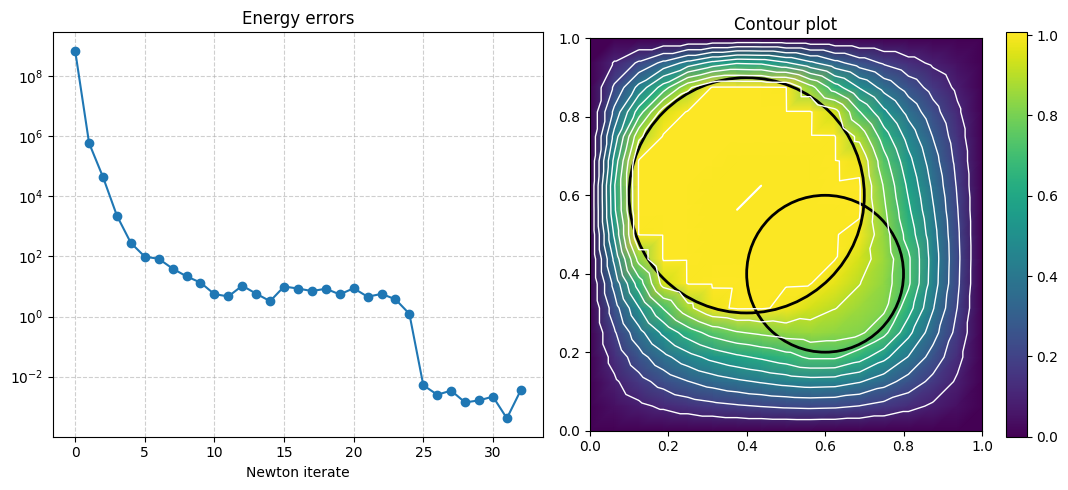

In [20]:
constrained_optimisation(nx=2**3, degree=14, gamma=2**32, max_iters=2**5, energy_exact=6.748865800378693)

Let's discuss a pretty robust alternative then...

## **Back to basics:** Gradient descent (GD)

Let's restrict our attention to energy minimisation problems.
You might never have seen GD in the function space setting before, but the idea's identical.
Instead of the update
$$
\mathbf{x}_{n+1} = \mathbf{x}_n - h\nabla E(\mathbf{x}_n),
$$
we have
$$
(u_{n+1}, v) = (u_n, v) - hE'(\mathbf{x}_n; v).
$$

So how does it square up against Newton?
Well, the convergence rates are **bad** (more on this later) but there are a lot of pros:

1. You get convergence for $h \in (0, 2/L)$, where $L$ is the Lipschitz constant of $E'$, i.e. such that.
The immediate consequence of this is that we need **one lower level of regularity**, i.e. we need only assert that $E$ is Lipschitz differentiable, not *twice* Lipschitz differentiable as in Newton.

2. This **convergence is guaranteed**, no matter where you start.
No need to stress about multiple solutions and attractive basins, no matter how nonlinear your problem.

3. The inner product we need to invert is always the **canonical inner product on our function space**.
Much less to re-assemble every iteration, and much, much easier to invert efficiently at high order.

I'll repeat though:
The convergence rates are **so, so bad**.
In the general infinite-dimensional case (i.e. as we PDE folks are interested in)* the energy converges at a rate $\mathcal{O}(n^{-1})$;
specifically, taking $h = 1/L$ (i.e. the optimal choice in general),
$$
E(\mathbf{x}_n) - E_\text{min}  \le  \frac{\|\mathbf{x}_0 - \mathbf{x}_\text{min}\|^2L}{2} \cdot \frac{1}{n}.
$$

> **Specifically, the case without "strong convexity".*

In [25]:
constrained_optimisation(nx=2**3, degree=14, gamma=2**32, max_iters=2**7, h=1.9, energy_exact=6.748865800378693)

Energy: 696964017.4677631
GD iterate 1...
Energy: 957889.9144886472
GD iterate 2...
Energy: 6859.955330201775
GD iterate 3...
Energy: 1989.5246487658062
GD iterate 4...
Energy: 1236.433962334348
GD iterate 5...
Energy: 952.9308609072133
GD iterate 6...
Energy: 840.8794134457211
GD iterate 7...
Energy: 796.2148103092566
GD iterate 8...
Energy: 777.993509541091
GD iterate 9...
Energy: 770.3010529165894
GD iterate 10...
Energy: 766.8832153683081
GD iterate 11...
Energy: 765.2196799280576
GD iterate 12...
Energy: 764.2837566531083
GD iterate 13...
Energy: 763.6628627483879
GD iterate 14...
Energy: 763.1860806150546
GD iterate 15...
Energy: 762.777228287004
GD iterate 16...
Energy: 762.4031321486317
GD iterate 17...
Energy: 762.0492105811064
GD iterate 18...
Energy: 761.7077084496037
GD iterate 19...
Energy: 761.373955468619
GD iterate 20...
Energy: 761.0451180783868
GD iterate 21...
Energy: 760.7194614314136
GD iterate 22...
Energy: 760.3958940411353
GD iterate 23...
Energy: 760.0737436335

KeyboardInterrupt: 

We can see that it's effectively stalled, with the solution looking like a shrinkwrap.
(Not to mention that's a log plot on the x axis now too.)

Let's investigate what's going on there with a little model problem...

## **2D demo**

Let's first check out that bound $h \in (0, 2L)$ on the step sizes.
We'll do this through GD on a super simple 2D quadratic function:
$$
E(x, y) := \frac{1}{2}x^2 + \frac{a}{2}y^2.
$$

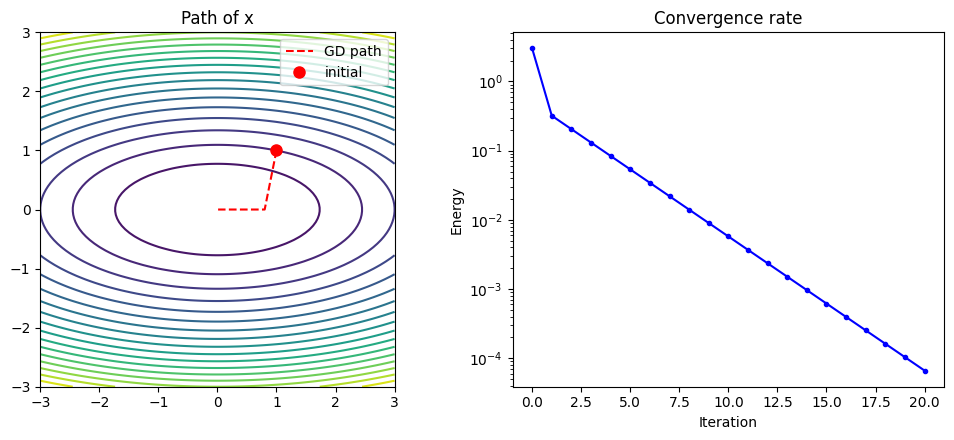

In [8]:
A = np.diag([1.0, 5.0])
gd_quad_plot2D(A=A, h=1.0)

Playing around with $h$, we see that, as expected, **step sizes outside** $(0, 2L)$ **break convergence**;

N.B. Don't be deceived by the exponential convergence you see here; this is expected in the finite dimensional case, for $n \ge d$.

In general, the path of the solution rushes to **resolve the steepest gradients in $E$ first**, then ***sloooooowly* makes its way up the shallow gradients**.
This corresponds with that "shrinkwrap" behaviour we saw in the obstacle problem!
The steepest gradients in $E$ there are associated with the large $\lambda \int_{u < f}(u - f)^2$;
it resolved those (i.e. lifts $u \ge f$) then *sloooooowly* resolves the remaining $\int \|\nabla u\|^2$ term everywhere else.

So, how might we speed this up?
We could try tweaking $h$ to get the fastest convergence rate possible...

*...but first, let's run **linesearch**, to get some idea maybe of what rate we should pick:*

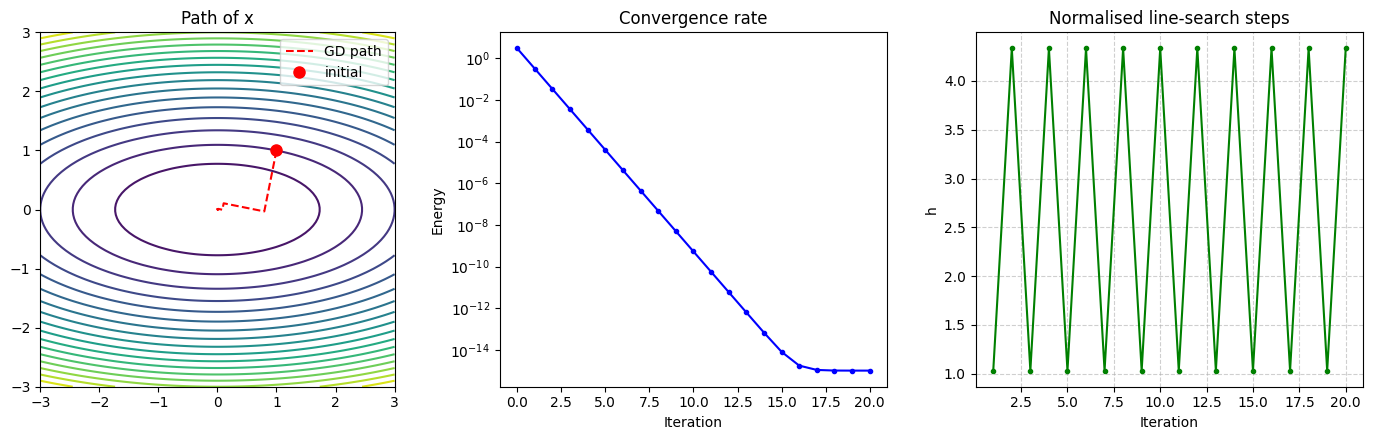

In [9]:
gd_quad_plot2D(A=A, h="linesearch")

Oh, that's interesting...

*...linesearch isn't taking uniform step sizes, but **alternating** between a **small one** and a **large one**.*

The small steps take you up the steep gradients, up to that centre manifold (the x axis) then the large ones hurry us along there.
In fact, these large step sizes are **so large** that it would normally be forbidden (i.e. much greater than $2/L$)!
This gives us an idea:

> *If we use **periodic patterns of step sizes**, we can accelerate the convergence!*

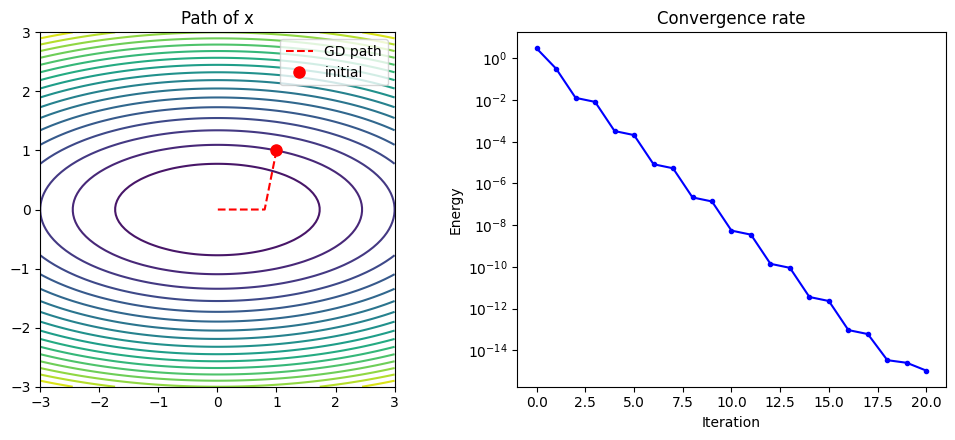

In [10]:
gd_quad_plot2D(A=A, h=np.array([1.0, 4.0]))

An immediate appeal of this is that we don't have to keep doing the potentially costly linesearch process, which involves many function evaluations.
It gets better than that though...

## **ND demo**

Let's up the dimension a little.
We'll use a **random PSD** $A \in \mathbb{R}^{1024 \times 1024}$, and define
$$
E(\mathbf{x})  =  \frac{1}{2} \mathbf{x}^\top A \mathbf{x}.
$$

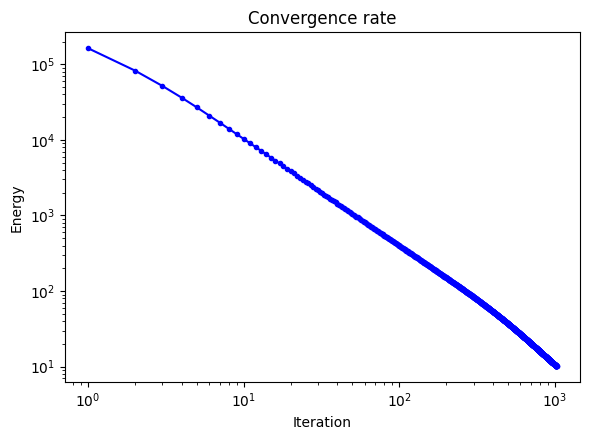

In [11]:
dim = 2**10
M = np.random.randn(dim, dim)
A = M.T @ M
gd_quad_plotND(A=A, h=1.0, n_steps=2**10)

At long last!
We reach the literature portion of this reading group...

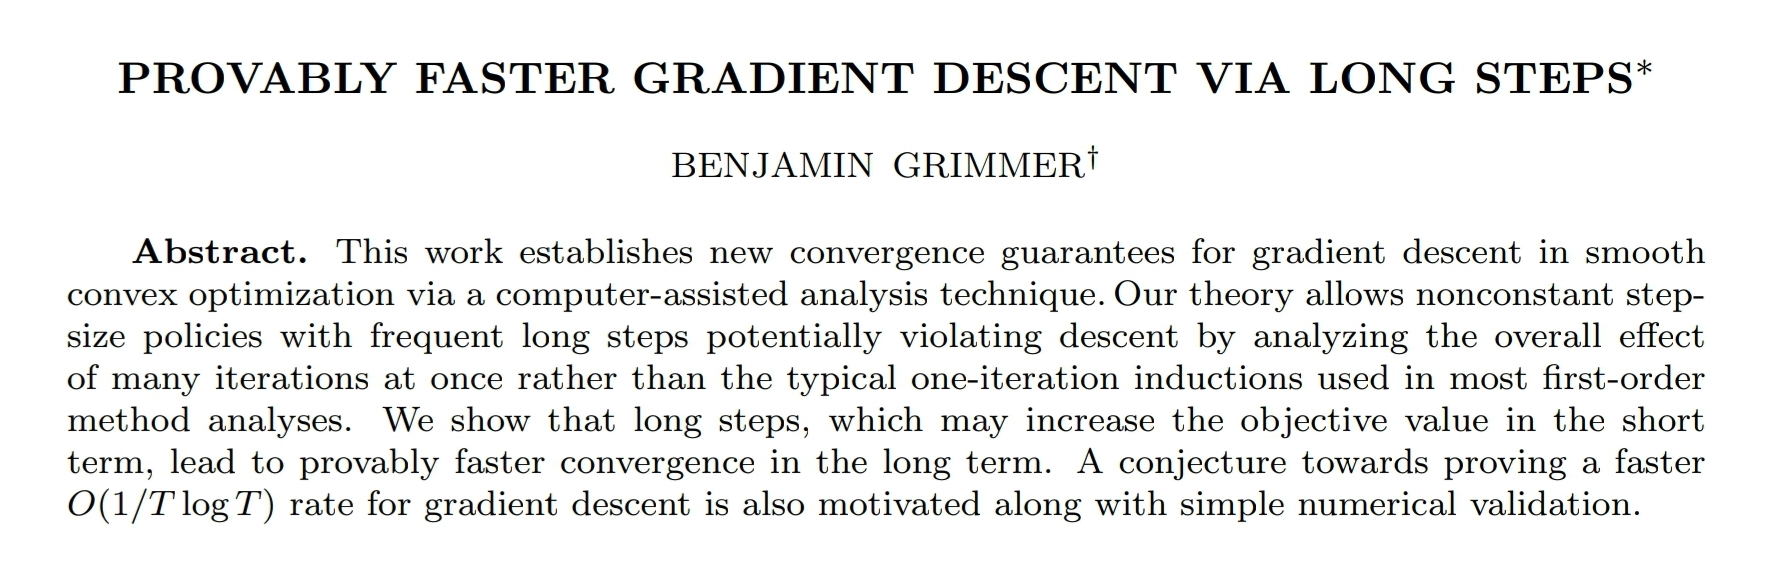

Last year, Grimmer defined various **periodic cycles** of **step sizes** that leverage this idea we saw from the model 2D demo above.
For each of these, he was able to prove they **retain** the **guaranteed convergence** of GD,* although now with faster convergence rates.

For example, while traditional GD always taking $h = 1/L$ has converge rates
$$
E(\mathbf{x}_n) - E_\text{min}  \le  \frac{\|\mathbf{x}_0 - \mathbf{x}_\text{min}\|^2L}{2} \cdot \frac{1}{n},
$$
he shows that cycling $h$ through $(1.5, 4.9, 1.5)/L$, this rate is improved by a constant factor:
$$
E(\mathbf{x}_n) - E_\text{min}  \le  \frac{\|\mathbf{x}_0 - \mathbf{x}_\text{min}\|^2L}{2} \cdot \frac{1}{2.63333... \cdot n}.
$$

> **The proof of this is pretty heavy-duty, and very optimisation-vibes, so I won't detail it here.*

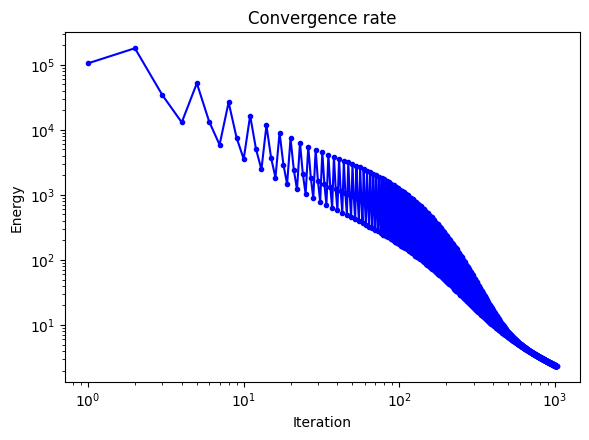

In [12]:
gd_quad_plotND(A=A, h=(1.5, 4.9, 1.5), n_steps=2**10)

A constant factor might not seem like much, but when you're talking about GD, that's a big deal.

Interesting, we can see these long steps sometimes cause a **temporary increase in the objective function**, with the benefit of faster convergence in the long run.

The cycles he finds are all of length $2^k - 1$, from length $3$ up to $127$:

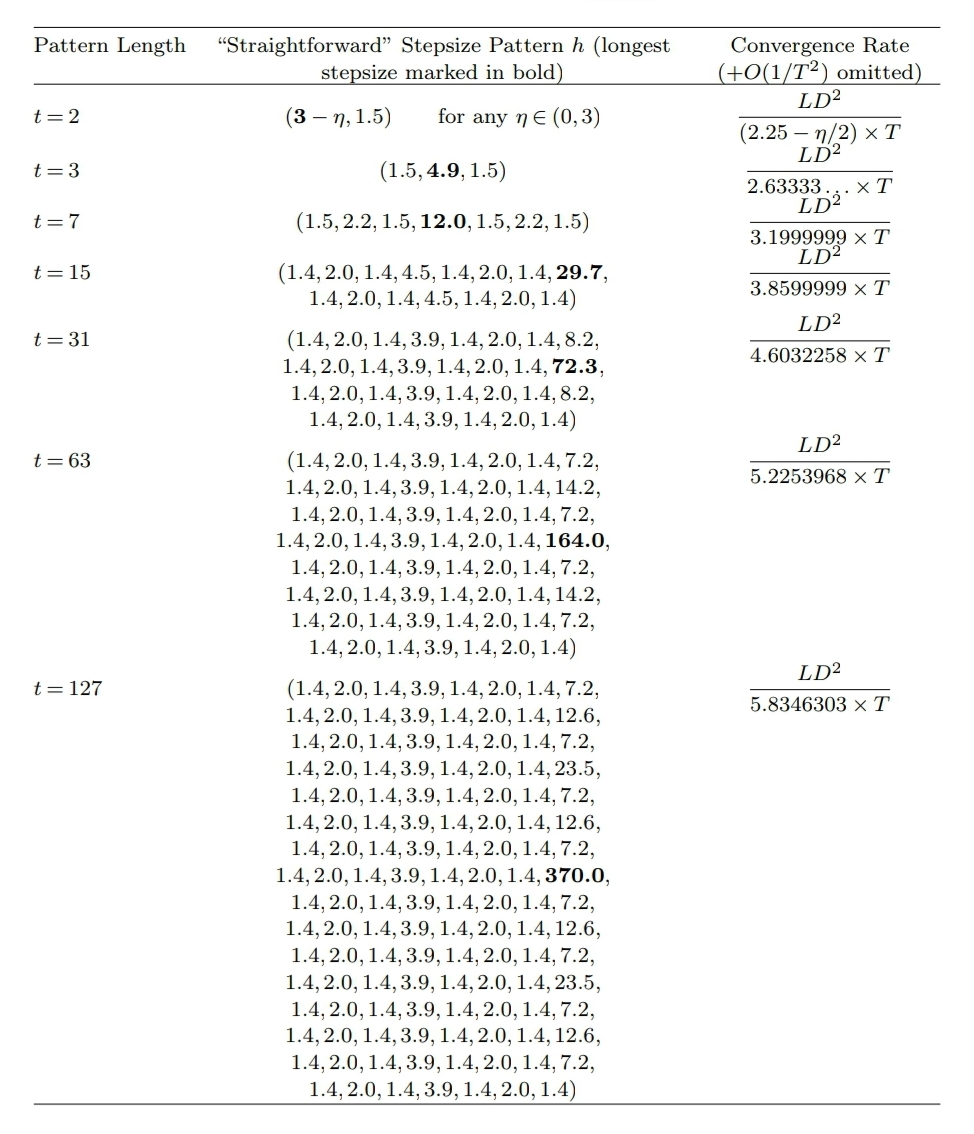

These patterns have a very curious behaviour.
Each step-size cycle of length $2^k - 1$ is obtained by concatenating:
$$
\text{length-$(2^{k-1} - 1)$ cycle} \quad \text{–} \quad \text{long step}_k  \quad \text{–} \quad \text{length-$(2^{k-1} - 1)$ cycle}
$$
I've found it pretty hard to describe this pattern*, but it's pretty obvious what I mean when you look at the numbers.

Here's how the length-$127$ cycle behaves, offering a speed-up of $\sim\!5.8$:

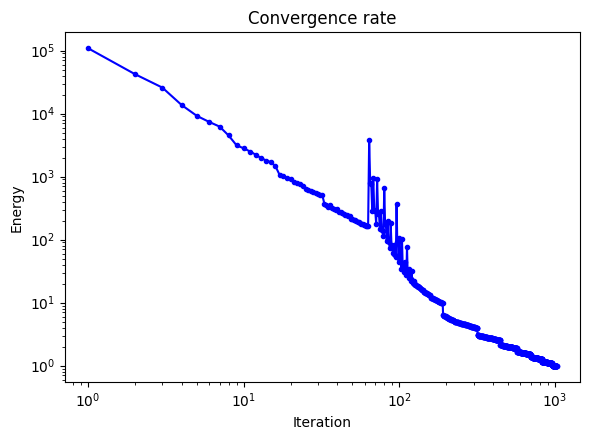

In [13]:
gd_quad_plotND(A=A,h=(1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,23.5,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,370.0,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,23.5,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4), n_steps=2**10)

I'd just like to highlight how **massive** that long step is.
We're taking, at the peak, $h = 370/L$, when previously I said we couldn't take $h \ge 2/L$ without breaking convergence!

We can see this does a lot better than linesearch too:

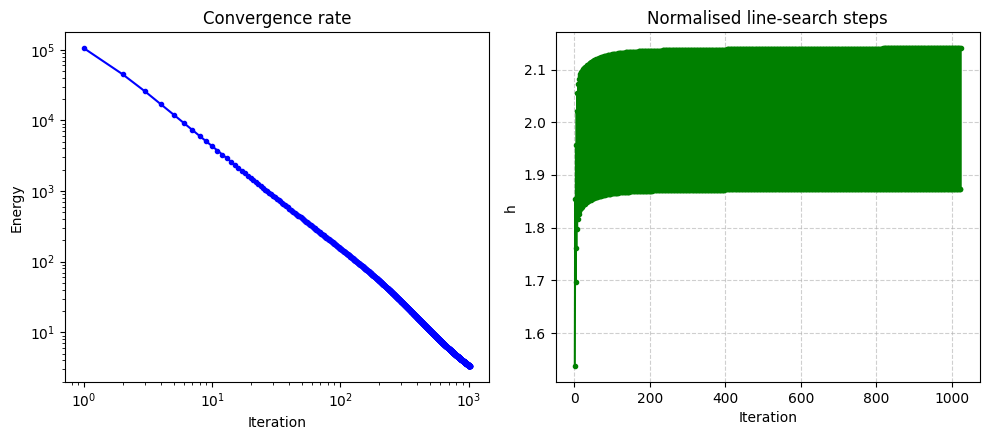

In [14]:
gd_quad_plotND(A=A, h="linesearch", n_steps=2**10)

So let's take this back to the obstacle problem from earlier...

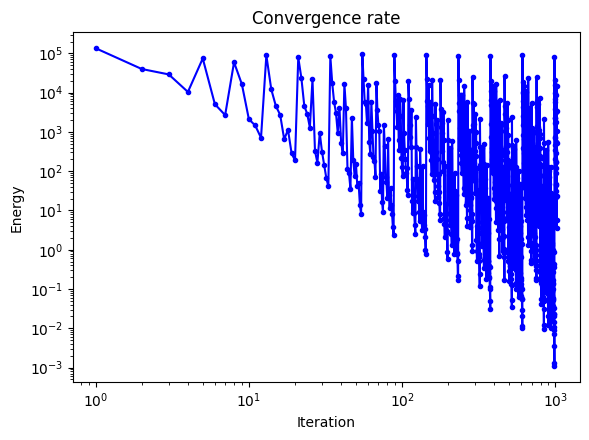

In [15]:
phi = (1 + np.sqrt(5))/2
gd_quad_plotND(A=A, h=[1/np.sin(phi * np.pi * (i+1))**2 for i in range(2**10)], n_steps=2**10)

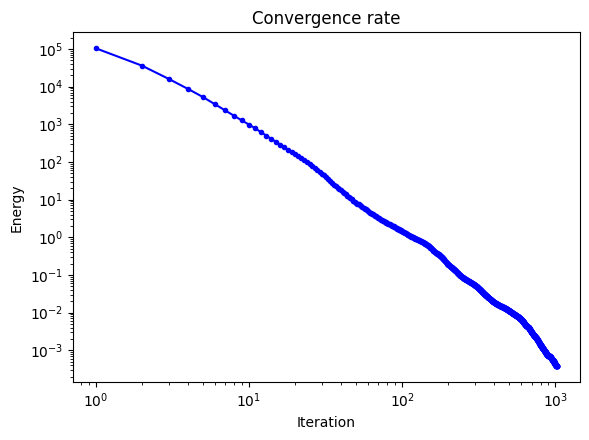

In [16]:
gd_quad_plotND(A=A, h="cg", n_steps=2**10)

## **The obstacle problem**: Revisited

Energy: 166.19993827160474
GD iterate 1, step size 1.4...
Energy: 15.707873839559076
GD iterate 2, step size 2.0...
Energy: 9.294724070156299
GD iterate 3, step size 1.4...
Energy: 7.666851187745535
GD iterate 4, step size 3.9...
Energy: 7.028460255013263
GD iterate 5, step size 1.4...
Energy: 6.209397784405093
GD iterate 6, step size 2.0...
Energy: 6.017018389149252
GD iterate 7, step size 1.4...
Energy: 5.834252239572367
GD iterate 8, step size 7.2...
Energy: 6.178097430678478
GD iterate 9, step size 1.4...
Energy: 5.643126509962743
GD iterate 10, step size 2.0...
Energy: 5.6304984519785
GD iterate 11, step size 1.4...
Energy: 5.547922656906357
GD iterate 12, step size 3.9...
Energy: 5.6425027703257316
GD iterate 13, step size 1.4...
Energy: 5.542332300662766
GD iterate 14, step size 2.0...
Energy: 5.540814542741584
GD iterate 15, step size 1.4...
Energy: 5.525354951190728
GD iterate 16, step size 12.6...
Energy: 5.891800278817118
GD iterate 17, step size 1.4...
Energy: 5.57866480636

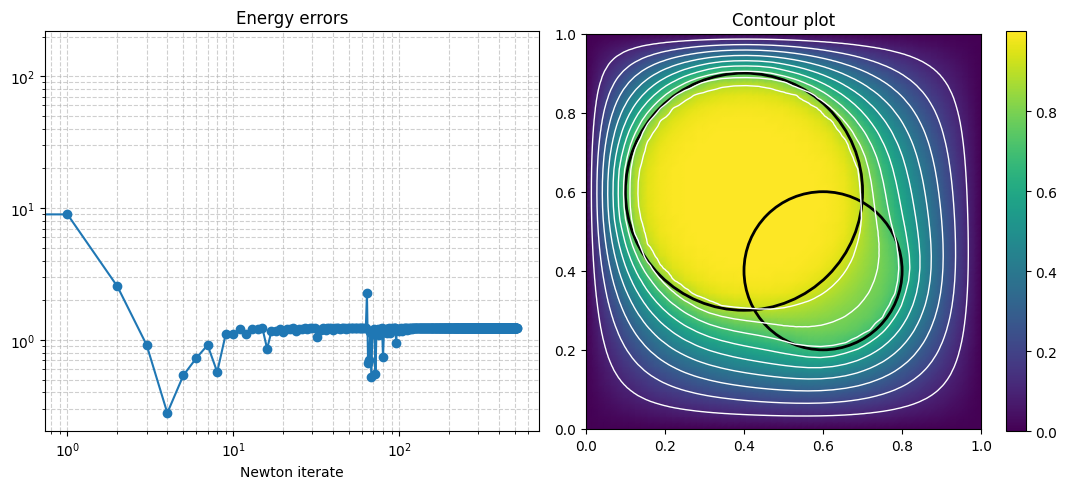

In [32]:
constrained_optimisation(nx=2**5, degree=1, gamma=2**10, max_iters=2**9, h=(1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,23.5,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,370.0,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,23.5,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4,12.6,1.4,2.0,1.4,3.9,1.4,2.0,1.4,7.2,1.4,2.0,1.4,3.9,1.4,2.0,1.4), energy_exact=6.748865800378693)